# Домашнее задание №3: Архитектуры GAN

**[0 баллов] Считайте изображение и получите две вариации изображения: HR, LR.**

In [54]:
# # скачаем изображение
!wget -O hr.png https://github.com/aiedu-courses/super_resolution/blob/main/data/hr.png?raw=true

In [1]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import torch

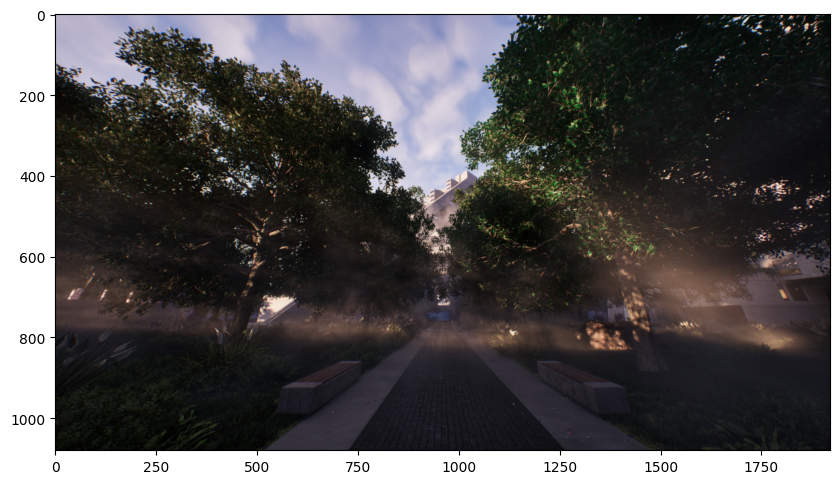

In [12]:
# считаем изображение при помощи библиотеки pillow и приведем к RGB формату
hr_img_raw = Image.open("../datasets/hr.png").convert("RGB")
_ = plt.figure(figsize=(10, 7))
_ = plt.imshow(hr_img_raw)

In [22]:
# случайным образом получим HR изображение размера (256, 256)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomCrop((256, 256))
    ]
)

# получим LR изображение размера (64, 64) при помощи простого resize
resize_transform = transforms.Resize((64, 64))

# tensor to PIL
tensor2pil = transforms.ToPILImage()

In [23]:
hr_img = transform(hr_img_raw)
lr_img = resize_transform(hr_img)

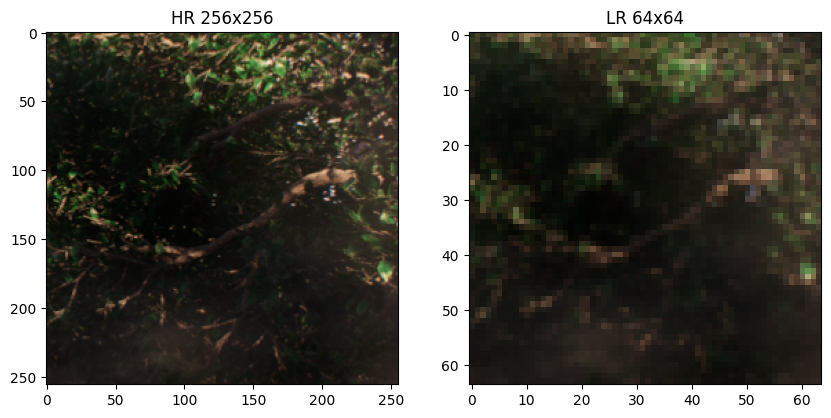

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(tensor2pil(hr_img))
ax[0].set_title("HR 256x256")

ax[1].imshow(tensor2pil(lr_img))
ax[1].set_title("LR 64x64")

plt.show()

In [60]:
hr_img = hr_img.unsqueeze(0)
lr_img = lr_img.unsqueeze(0)

### **[0 баллов] Подсчет параметров модели**

In [61]:
# возьмите реализацию функции из ДЗ №2: Архитектуры CNN
def calculate_total_parameters(model: nn.Module) -> int:
    """
        Parameters
        ----------
        model: nn.Module
            Объект PyTorch модели.

        Returns
        -------
        int
            Число всех параметров модели.
    """
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

### **[8 баллов]** SRGAN: генератор

In [62]:
# реализуйте объявленные методы класса
class ResBlock(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 64,
        kernel_size: int = 3,
        padding: int = 1,
        stride: int = 1) -> None:
        """
            Residual блок: Conv -> BN -> PReLU -> Conv -> BN -> F(x) + x.

            Returns
            -------
            None
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += x

        return out

In [63]:
# реализуйте объявленные методы класса
class SRGAN_Up(nn.Module):
    def __init__(self,
                factor: int,
                in_channels: int = 3,
                kernel_size: int = 3,
                padding: int = 1,
                stride: int = 1
                 ) -> None:
        """
            Parameters
            ----------
            factor: int
                Коэффициент увеличения [2|3|4].

            Returns
            -------
            None
        """
        super().__init__()
        self.factor = factor
        if factor == 2:
          self.conv = nn.Conv2d(in_channels, in_channels * 4, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
          self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)
          self.prelu = nn.PReLU()
        elif factor == 3:
          self.conv = nn.Conv2d(in_channels, in_channels * 9, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
          self.pixel_shuffle = nn.PixelShuffle(upscale_factor=3)
          self.prelu = nn.PReLU()
        elif factor == 4:
          self.conv1 = nn.Conv2d(in_channels, in_channels * 4, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
          self.pixel_shuffle1 = nn.PixelShuffle(upscale_factor=2)
          self.prelu1 = nn.PReLU()
          self.conv2 = nn.Conv2d(in_channels, in_channels * 4, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
          self.pixel_shuffle2 = nn.PixelShuffle(upscale_factor=2)
          self.prelu2 = nn.PReLU()
        else:
          raise NotImplementedError

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        if self.factor in [2, 3]:
          out = self.conv(x)
          out = self.pixel_shuffle(out)
          out = self.prelu(out)
        elif self.factor == 4:
          out = self.conv1(x)
          out = self.pixel_shuffle1(out)
          out = self.prelu1(out)
          out = self.conv2(out)
          out = self.pixel_shuffle2(out)
          out = self.prelu2(out)
        else:
          raise NotImplementedError
        return out



In [64]:
# реализуйте объявленные методы класса
class SRGAN_G(nn.Module):
    def __init__(self, nchannels: int = 3, out_channels: int = 64, nblocks: int = 16, scale: int = 4) -> None:
        """
            Parameters
            ----------
            nchannels: int
                Количество каналов входного изображения.
            nblocks: int
                Количество ResBlock блоков.
            scale: int
                Коэффициент увеличения [2|3|4].

            Returns
            -------
            None
        """
        super().__init__()
        self.nchannels = nchannels
        self.out_channels = out_channels
        self.nblocks = nblocks
        self.scale = scale

        self.conv_first = nn.Conv2d(nchannels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.prelu = nn.PReLU()

        self.res_blocks = []
        for i in range(self.nblocks):
            self.res_blocks.append(ResBlock(in_channels=self.out_channels))

        self.conv_middle = nn.Conv2d(nchannels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.out_channels)

        self.upscale = SRGAN_Up(factor=self.scale, in_channels=self.out_channels)
        self.conv_last = nn.Conv2d(self.out_channels, nchannels, kernel_size=3, stride=1, padding=1, bias=False)


    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        out = self.conv_first(x)
        prelu = self.prelu(out)
        out = self.res_blocks[0](prelu)
        for res_block in self.res_blocks[1:]:
          out = res_block(out)
        out += prelu
        out = self.upscale(out)
        out = self.conv_last(out)

        return out

In [65]:
# создадим SRGAN генератор и напечатаем его архитектуру
srgan_g = SRGAN_G(scale=4)
srgan_g

SRGAN_G(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (prelu): PReLU(num_parameters=1)
  (conv_middle): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upscale): SRGAN_Up(
    (conv1): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pixel_shuffle1): PixelShuffle(upscale_factor=2)
    (prelu1): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pixel_shuffle2): PixelShuffle(upscale_factor=2)
    (prelu2): PReLU(num_parameters=1)
  )
  (conv_last): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [66]:
# посчитаем количество параметров модели
print(f"SRGAN generator parameters = {calculate_total_parameters(srgan_g)}")

SRGAN generator parameters = 300227


In [67]:
# проверка на корректность размерностей
assert srgan_g(lr_img).shape == (1, 3, 256, 256)

### **[8 баллов]** ESRGAN: генератор

In [68]:
# реализуйте объявленные методы класса
class DenseBlock(nn.Module):
    def __init__(self,
                 nf: int = 64,
                 gc: int = 32,
                 residual_scaling: float = 0.2,
                 kernel_size: int = 3,
                 padding: int = 1,
                 stride: int = 1,
                 n_res_blocks: int = 5) -> None:
        """
            Parameters
            ----------
            nf: int
                Количество входных и выходных каналов блока.
            gc: int
                Количество скрытых каналов блока.
            residual_scaling: float
                Коэффициент умножения выходов блока перед сложением с предыдущим слоем.

            Returns
            -------
            None
        """
        super().__init__()
        self.residual_scaling = residual_scaling
        self.n_res_blocks = n_res_blocks
        self.cat_results = []

        self.res_blocks = []
        for i in range(self.n_res_blocks):
            self.res_blocks.append(
                ResBlockWoBN(nf + i * gc , gc)
            )

        self.conv_last = nn.Conv2d(nf + (self.n_res_blocks - 1) * gc, nf, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        self.cat_results = []
        out = self.res_blocks[0](x)
        self.cat_results.append(out)

        for i in range(1, len(self.res_blocks) - 1):
            cat = torch.cat((x, *self.cat_results[:i]), dim=1)
            out = self.res_blocks[i](cat)
            self.cat_results.append(out)
        out = self.conv_last(torch.cat((x, *self.cat_results), dim=1))
        out = self.residual_scaling * out + x

        return out


class ResBlockWoBN(nn.Module):
    def __init__(
        self,
        nf: int = 64,
        gc: int = 32,
        kernel_size: int = 3,
        padding: int = 1,
        stride: int = 1) -> None:
        """
            Residual блок без Batch Normalization: Conv -> LReLU -> F(x) + x.

            Returns
            -------
            None
        """
        super().__init__()
        self.nf = nf
        self.conv = nn.Conv2d(nf, gc, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.lrelu = nn.LeakyReLU()

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        out = self.conv(x)
        out = self.lrelu(out)

        return out

In [69]:
# реализуйте объявленные методы класса
class RRDB(nn.Module):
    def __init__(self,
                 nf: int = 64,
                 gc: int = 32,
                 residual_scaling: float = 0.2,
                 n_dense_blocks: int = 5,
                 n_res_blocks: int = 5) -> None:
        """
            Parameters
            ----------
            nf: int
                Количество входных и выходных каналов блока.
            gc: int
                Количество скрытых каналов блока.
            residual_scaling: float
                Коэффициент умножения выходов блока перед сложением с предыдущим слоем.

            Returns
            -------
            None
        """
        super().__init__()
        self.residual_scaling = residual_scaling
        self.rrd_blocks = []
        for _ in range(n_dense_blocks):
          self.rrd_blocks.append(DenseBlock(nf, gc, residual_scaling, n_res_blocks=n_res_blocks))


    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        out = self.rrd_blocks[0](x)
        for rrd_block in self.rrd_blocks[1:]:
          out = rrd_block(out)
        out = self.residual_scaling * out + x

        return out


In [70]:
# реализуйте объявленные методы класса
class ESRGAN_Up(nn.Module):
    def __init__(self,
                 factor: int,
                 mode: str = "nearest",
                 in_channels: int = 32,
                 kernel_size: int = 3,
                 padding: int = 1,
                 stride: int = 1) -> None:
        """
            Parameters
            ----------
            factor: int
                Коэффициент увеличения [2|3|4].
            mode: str
                Тип интерполяции [bicubic|bilinear|nearest].

            Returns
            -------
            None
        """
        super().__init__()
        self.factor = factor
        self.mode = mode

        if self.factor in [2, 3]:
          self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        if self.factor == 4:
          self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
          self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        if self.factor in [2, 3]:
          out = self.conv(x)
          inter_out = torch.nn.functional.interpolate(
              out, scale_factor=self.factor, mode=self.mode
              )
          return inter_out
        elif self.factor == 4:
          out = self.conv1(x)
          inter_out = torch.nn.functional.interpolate(
              out, scale_factor=2, mode=self.mode
              )
          out = self.conv2(inter_out)
          inter_out = torch.nn.functional.interpolate(
              out, scale_factor=2, mode=self.mode
              )
          return inter_out


In [71]:
# реализуйте объявленные методы класса
class ESRGAN_G(nn.Module):
    def __init__(
            self,
            nchannels: int = 3,
            nblocks: int = 16,
            n_res_blocks: int = 5,
            n_dense_blocks: int = 5,
            nf: int = 64,
            gc: int = 32,
            scale: int = 4,
            residual_scaling: float = 0.2,
            interpolation_mode: str = "nearest",
            kernel_size: int = 3,
            padding: int = 1,
            stride: int = 1
        ) -> None:
        """
            Parameters
            ----------
            nchannels: int
                Количество каналов входного изображения.
            nblocks: int
                Количество RRDB блоков.
            nf: int
                Количество входных и выходных каналов для RRDB блоков.
            gc: int
                Количество скрытых каналов для RRDB блоков.
            scale: int
                Коэффициент увеличения [2|3|4].
            residual_scaling: float
                Коэффициент умножения выходов блока перед сложением с предыдущим слоем.
            interpolation_mode: str
                Тип интерполяции для upsample блоков [bicubic|bilinear|nearest].

            Returns
            -------
            None
        """
        super().__init__()
        self.conv_first = nn.Conv2d(nchannels, nf, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.basic_blocks = []
        for i in range(nblocks):
          self.basic_blocks.append(RRDB(
              nf=nf, gc=gc, residual_scaling=residual_scaling, n_dense_blocks=n_dense_blocks, n_res_blocks=n_res_blocks
          ))
        self.conv_blocks = nn.Conv2d(nf, nf, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.upsampling = ESRGAN_Up(scale, mode=interpolation_mode, in_channels=nf)
        self.conv_upcorr = nn.Conv2d(nf, nchannels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.conv_last = nn.Conv2d(nchannels, nchannels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)


    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        out_conv_first = self.conv_first(x)
        out_basic_blocks = self.basic_blocks[0](out_conv_first)
        for basic_block in self.basic_blocks[1:]:
          out_basic_blocks = basic_block(out_basic_blocks)
        out_conv_blocks = self.conv_blocks(out_basic_blocks)

        out = out_conv_first + out_conv_blocks
        out = self.upsampling(out)
        out = self.conv_upcorr(out)
        out = self.conv_last(out)

        return out

In [72]:
# создадим ESRGAN генератор и напечатаем его архитектуру
esrgan_g = ESRGAN_G(scale=4)
esrgan_g

ESRGAN_G(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv_blocks): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (upsampling): ESRGAN_Up(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv_upcorr): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv_last): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [73]:
# посчитаем количество параметров модели
print(f"ESRGAN generator parameters = {calculate_total_parameters(esrgan_g)}")

ESRGAN generator parameters = 114129


In [74]:
# проверка на корректность размерностей
assert esrgan_g(lr_img).shape == (1, 3, 256, 256)

torch.Size([1, 64, 64, 64])


### **[8 баллов]** Дискриминатор

In [75]:
# реализуйте объявленные методы класса
class DiscriminatorBlock(nn.Module):
    def __init__(self, inf: int,
                 outf: int,
                 stride: int,
                 kernel_size: int = 3,
                 padding: int = 1,
                 use_bn: bool = True) -> None:
        """
            Блок дискриминатора SRGAN: Conv -> BN -> LeakyReLU.

            Parameters
            ----------
            inf: int
                Количество каналов входного изображения.
            outf: int
                Количество каналов выходного изображения.
            stride: int
                Шаг свертки [1|2].
            use_bn: bool
                Флаг использования слоя BN.

            Returns
            -------
            None
        """
        super().__init__()
        self.use_bn = use_bn
        self.conv_first = nn.Conv2d(inf, outf, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(outf)
        self.lrelu = nn.LeakyReLU()

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        out = self.conv_first(x)
        if self.use_bn:
            out = self.bn(out)
        out = self.lrelu(out)
        return out

In [76]:
# реализуйте объявленные методы класса
class Discriminator(nn.Module):
    def __init__(self,
                 nchannels: int = 3,
                 out_channels: int = 64,
                 nblocks: int = 8,
                 dense_neurons: int = 1024,
                 use_sigmoid: bool = False) -> None:
        """
            Parameters
            ----------
            nchannels: int
                Количество каналов входного изображения.
            nblocks: int
                Количество DiscriminatorBlock блоков.
            use_sigmoid: bool
                Флаг использования сигмоидальной функции активации после последнего слоя.

            Returns
            -------
            None
        """
        super().__init__()
        self.use_sigmoid = use_sigmoid
        self.basic_blocks = []
        self.basic_blocks.append(DiscriminatorBlock(nchannels, out_channels, stride=1, use_bn=False))
        self.basic_blocks.append(DiscriminatorBlock(out_channels, out_channels * 2, stride=2))
        for i in range(1, nblocks // 2):
            curr_out_channels = out_channels * (2 ** i)
            self.basic_blocks.append(
                DiscriminatorBlock(curr_out_channels, curr_out_channels, stride=1)
            )
            self.basic_blocks.append(
                DiscriminatorBlock(curr_out_channels, curr_out_channels * 2, stride=2)
            )
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(dense_neurons*(2**(nblocks // 2))**2, dense_neurons)
        self.lrelu = nn.LeakyReLU()
        self.dense_out = nn.Linear(dense_neurons, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
            Parameters
            ----------
            x: torch.FloatTensor
                Входной тензор формата (bs, c, h, w).

            Returns
            -------
            torch.FloatTensor
                Выходной тензор, получается путем применения слоев к входному тензору.
        """
        out = self.basic_blocks[0](x)
        out = self.basic_blocks[1](out)
        for basic_block in self.basic_blocks[2:]:
            out = basic_block(out)
        out = torch.flatten(out, 1)
        out = self.dense(out)
        out = self.lrelu(out)
        out = self.dense_out(out)
        if self.use_sigmoid:
            out = self.sigmoid(out)
        return out

In [77]:
# создадим дискриминатор и напечатаем его архитектуру
discriminator = Discriminator()
discriminator

Discriminator(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=262144, out_features=1024, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (dense_out): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [78]:
# посчитаем количество параметров модели
print(f"Discriminator parameters = {calculate_total_parameters(discriminator)}")

Discriminator parameters = 268437505


In [79]:
# проверка на корректность размерностей
assert discriminator(srgan_g(lr_img)).shape == (1, 1)
assert discriminator(srgan_g(lr_img)).shape == discriminator(hr_img).shape
assert discriminator(esrgan_g(lr_img)).shape == (1, 1)
assert discriminator(esrgan_g(lr_img)).shape == discriminator(hr_img).shape

torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])


### **[1 балл] Feedback**

Напишите ваши эмоции от этого домашнего задания, было ли оно интересным, оцените сложность, затраты по времени и т.п., все что пожелаете :)

Никогда не интересовался реализацией архитектуры GAN, поэтому было достаточно сложно, но интересно. Ушло где-то порядка 7 вечеров (по 3-4 часа), но очень понравилось. Вообще нравится формат заданий, где надо писать архитектуру сети с нуля - так усваивается лучше всего. 